In [1]:
import pandas as pd
import numpy as np
import cobra
from pathlib import Path
import seaborn as sns
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt
from collections import OrderedDict
import scipy as sp
import statsmodels.api as sm
import scipy.stats as st
from statannotations.Annotator import Annotator


In [492]:
# Load ecoli model
model_ez = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [538]:
# Load ecoli model
model_e = cobra.io.read_sbml_model('../models/e_coli/iML1515.xml')
model_e.solver = 'gurobi'

In [3]:
fn = '../models/iYL1228.xml'
model_k = cobra.io.read_sbml_model(fn)
model_k.solver = 'gurobi'

In [4]:
fn = '../models/iJN1463.xml'
model_p = cobra.io.read_sbml_model(fn)
model_p.solver = 'gurobi'

In [491]:
# fn = '../models/b_licheniformis/iBsu1147_irr_enz_constraint_adj.xml'
# model_pz = cobra.io.read_sbml_model(fn)
# model_pz.solver = 'gurobi'

In [5]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-SINTEF/UNIL/leakage/data/Vila et al., 2023')

In [6]:
untargeted_fn = folder / 'Untargeted_LCMS.csv'
dfu = pd.read_csv(untargeted_fn)
targeted_fn = folder / 'Targeted_LCMS.csv'
dft = pd.read_csv(targeted_fn)

In [651]:
dfu.Metabolite.unique()

array(["2',4'-Dihydroxyacetophenone", '2,3-Diaminopropionic acid',
       '2-Hydroxybutyric acid', '2-Hydroxyglutaric acid',
       '2-Ketobutyric acid/Succinic acid semialdehyde',
       '2/3-Phosphoglyceric acid', '3-(2-Hydroxyphenyl)propanoic acid',
       '3-Amino-4-hydroxybenzoic acid', '3-Hydroxybenzoic acid',
       '3-Hydroxyphenylacetic acid', '4-Guanidinobutanoic acid',
       '4-Hydroxyphenylpyruvic acid', '4-Hydroxyproline',
       '4-hydroxy-L-phenylglycine', 'Acetylglycine',
       "Adenosine 2',3'-cyclic phosphate", 'Adenosine monophosphate',
       'Alanine/Sarcosine', 'Aminoadipic acid', 'Citric/Isocitric acid',
       'Cyclic AMP', 'Deoxyguanosine', 'Dethiobiotin', 'FAD',
       'Fructose 6-phosphate', 'Fumaric acid', 'Gluconic acid',
       'Glucosamine 6-phosphate', 'Glucosamine 6-sulfate',
       'Glucurono-6,3-lactone', 'Glycocholic acid', 'Guanine',
       'Guanosine monophosphate', 'Homocystine',
       'Hydroxyphenyllactic acid', 'Hypoxanthine', 'Imidazoleaceti

## Carbon source to color

In [8]:
cs_to_type_map = {}
cs_to_color_map = {}
type_to_color = {'A':'g', 'S':'r'}
for cs in dfu.Carbon_Source.unique():
    idx = dfu.Carbon_Source==cs
    type_ = dfu.loc[idx, 'Type'].values[0]
    cs_to_type_map[cs] = type_
    cs_to_color_map[cs] = type_to_color[type_]

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


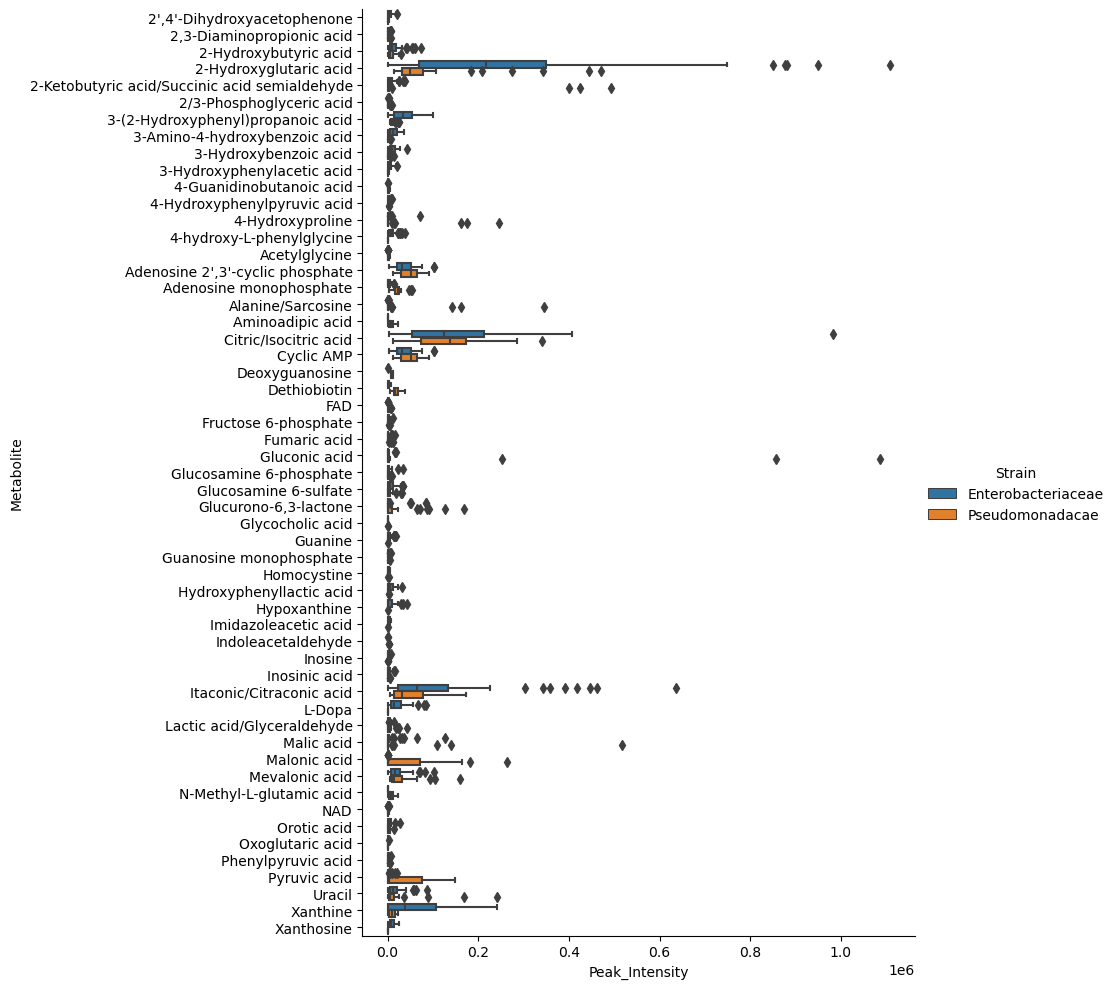

In [9]:
x = 'Peak_Intensity'
y = 'Metabolite'
sns.catplot(data = dfu, x = x, y = y, hue = 'Strain', kind = 'box', height=10, aspect=1)#, order = order)


# Normalization

In [25]:
metabolites = dfu.Metabolite.unique()
key = 'Peak_Intensity'
# key2 = 'Normalized peak 1'
# dfu[key2] = dfu[key]/(dfu['OD']**4)
# for s in dfu.Strain.unique():
#     sidx = dfu.Strain == s
for m in metabolites:
    # Normalize both plates together?
    idx = (dfu.Metabolite == m)#&sidx
    # dfu.loc[idx, 'Max-scaled'] = dfu.loc[idx, key]/np.max(dfu.loc[idx, key])
    dfu.loc[idx, 'Z-score'] = (dfu.loc[idx, key]-dfu.loc[idx, key].mean())/dfu.loc[idx, key].std()
    logscaled = np.log10(dfu.loc[idx, key])
    logscaled.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfu.loc[idx, 'Z-score(log)'] = (logscaled-np.nanmean(logscaled))/np.nanstd(logscaled)
    # dfu.loc[idx, 'Z-score/OD'] = (dfu.loc[idx, key2]-dfu.loc[idx, key2].mean())/dfu.loc[idx, key2].std()


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [652]:
s1idx = dfu.Strain == s1
s2idx = dfu.Strain == s2
mean_key = 'Oxoglutaric acid'#'Fumaric acid'
mean_idx = dfu.Metabolite == mean_key
dfu['log10(PI)'] = np.log10(dfu['Peak_Intensity'])
dfu.replace([-np.inf, np.inf], np.nan, inplace=True)
# mean_mv_diff = met_value_df[sm1idx&mean_idx, 'log10(Metabolite value)'].mean() - met_value_df[sm2idx&mean_idx, 'log10(Metabolite value)'].mean()
dfu.loc[s1idx, f'{mean_key}-log10(PI)'] = dfu.loc[s1idx, 'log10(PI)'] - dfu.loc[s1idx&mean_idx, 'log10(PI)'].median()
dfu.loc[s2idx, f'{mean_key}-log10(PI)'] = dfu.loc[s2idx, 'log10(PI)'] - dfu.loc[s2idx&mean_idx, 'log10(PI)'].median()



/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


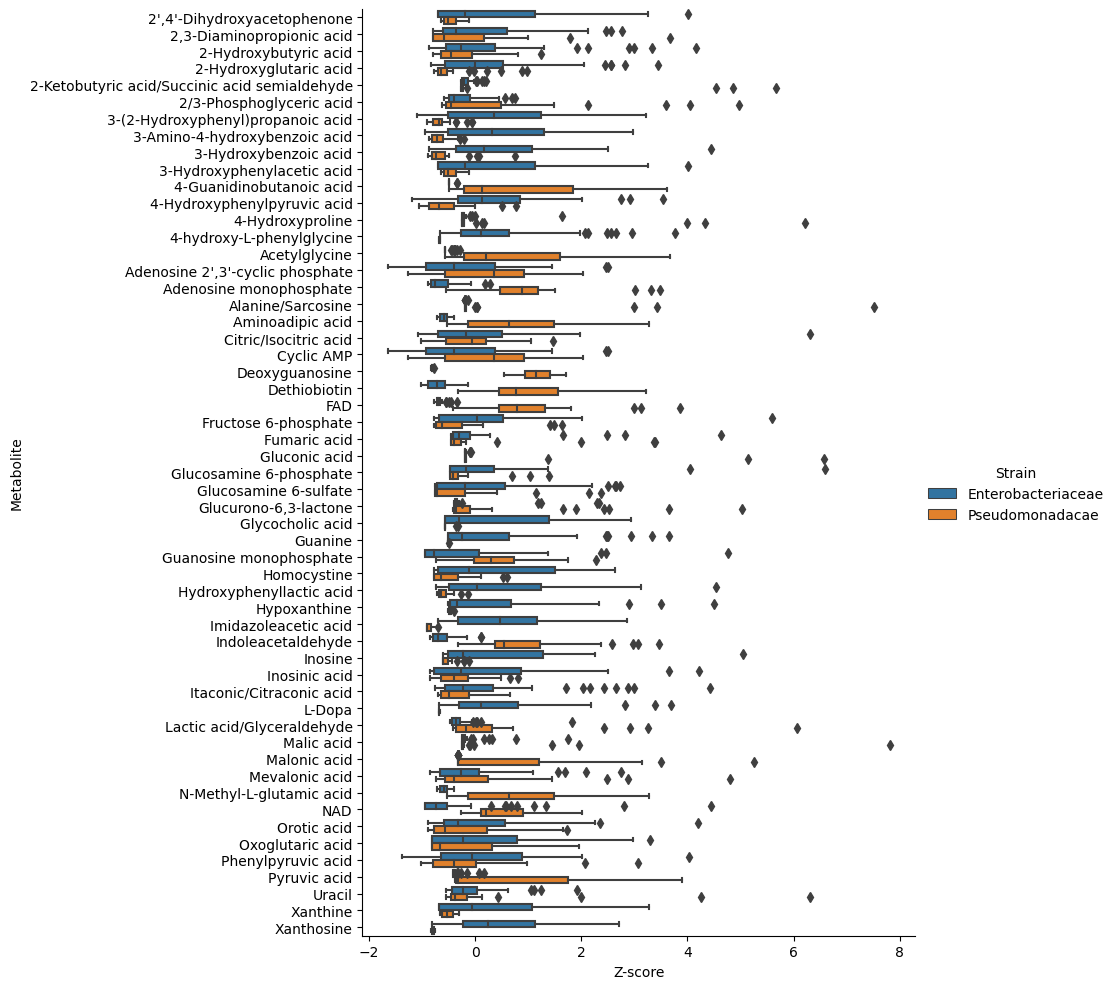

In [653]:
x = 'Z-score'
y = 'Metabolite'
sns.catplot(data = dfu, x = x, y = y, hue = 'Strain', kind = 'box', height=10, aspect=1)#, order = order)
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


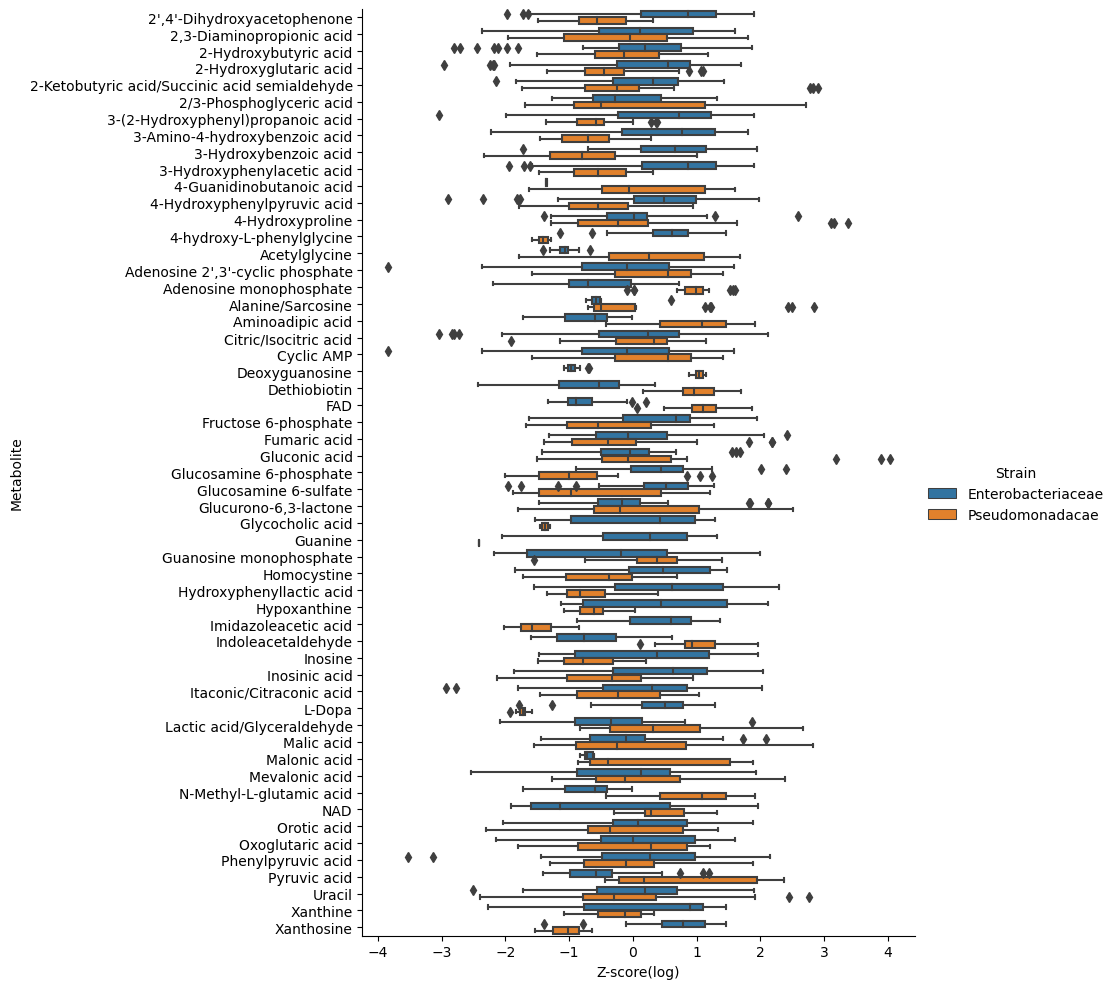

In [654]:
x = 'Z-score(log)'
y = 'Metabolite'
sns.catplot(data = dfu, x = x, y = y, hue = 'Strain', kind = 'box', height=10, aspect=1)#, order = order)
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


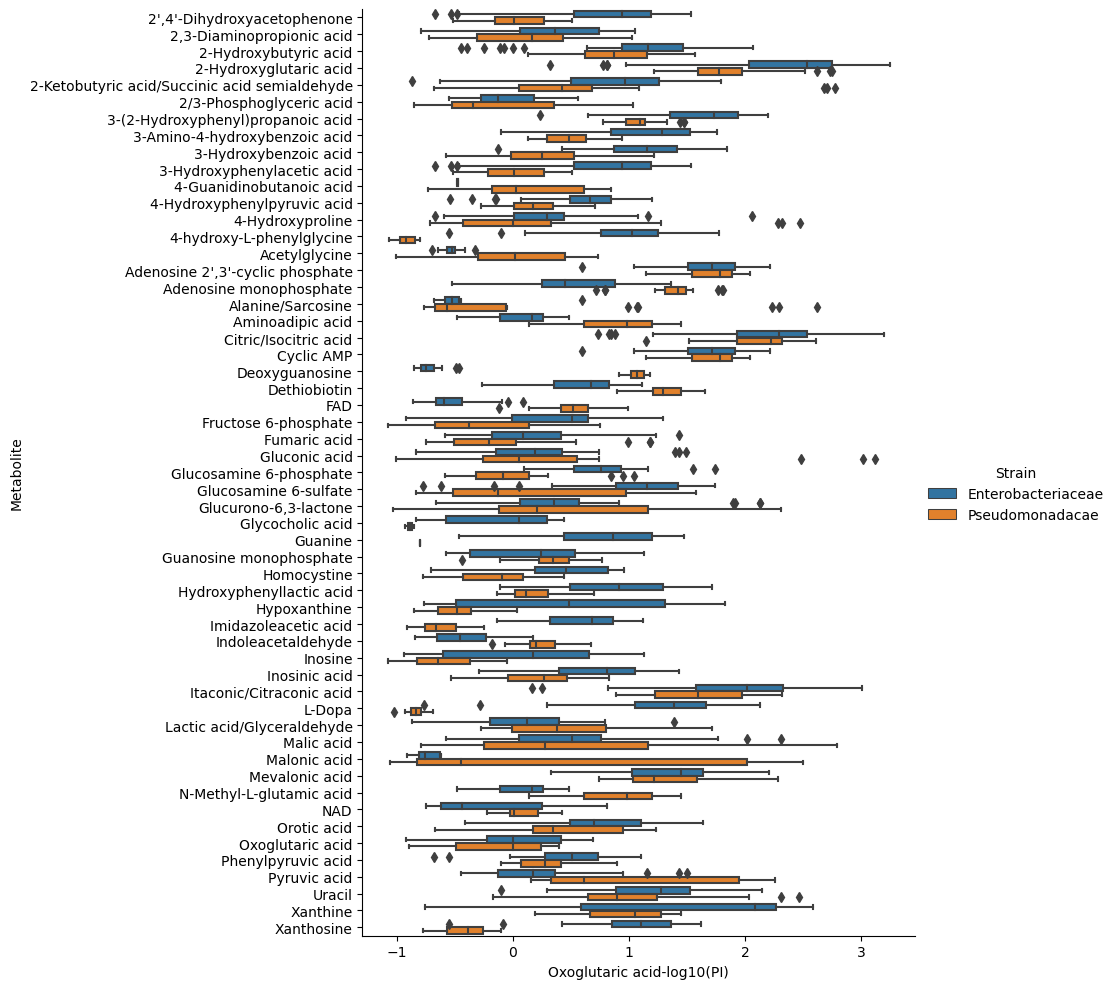

In [655]:
x = f'{mean_key}-log10(PI)'
y = 'Metabolite'
sns.catplot(data = dfu, x = x, y = y, hue = 'Strain', kind = 'box', height=10, aspect=1)#, order = order)
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


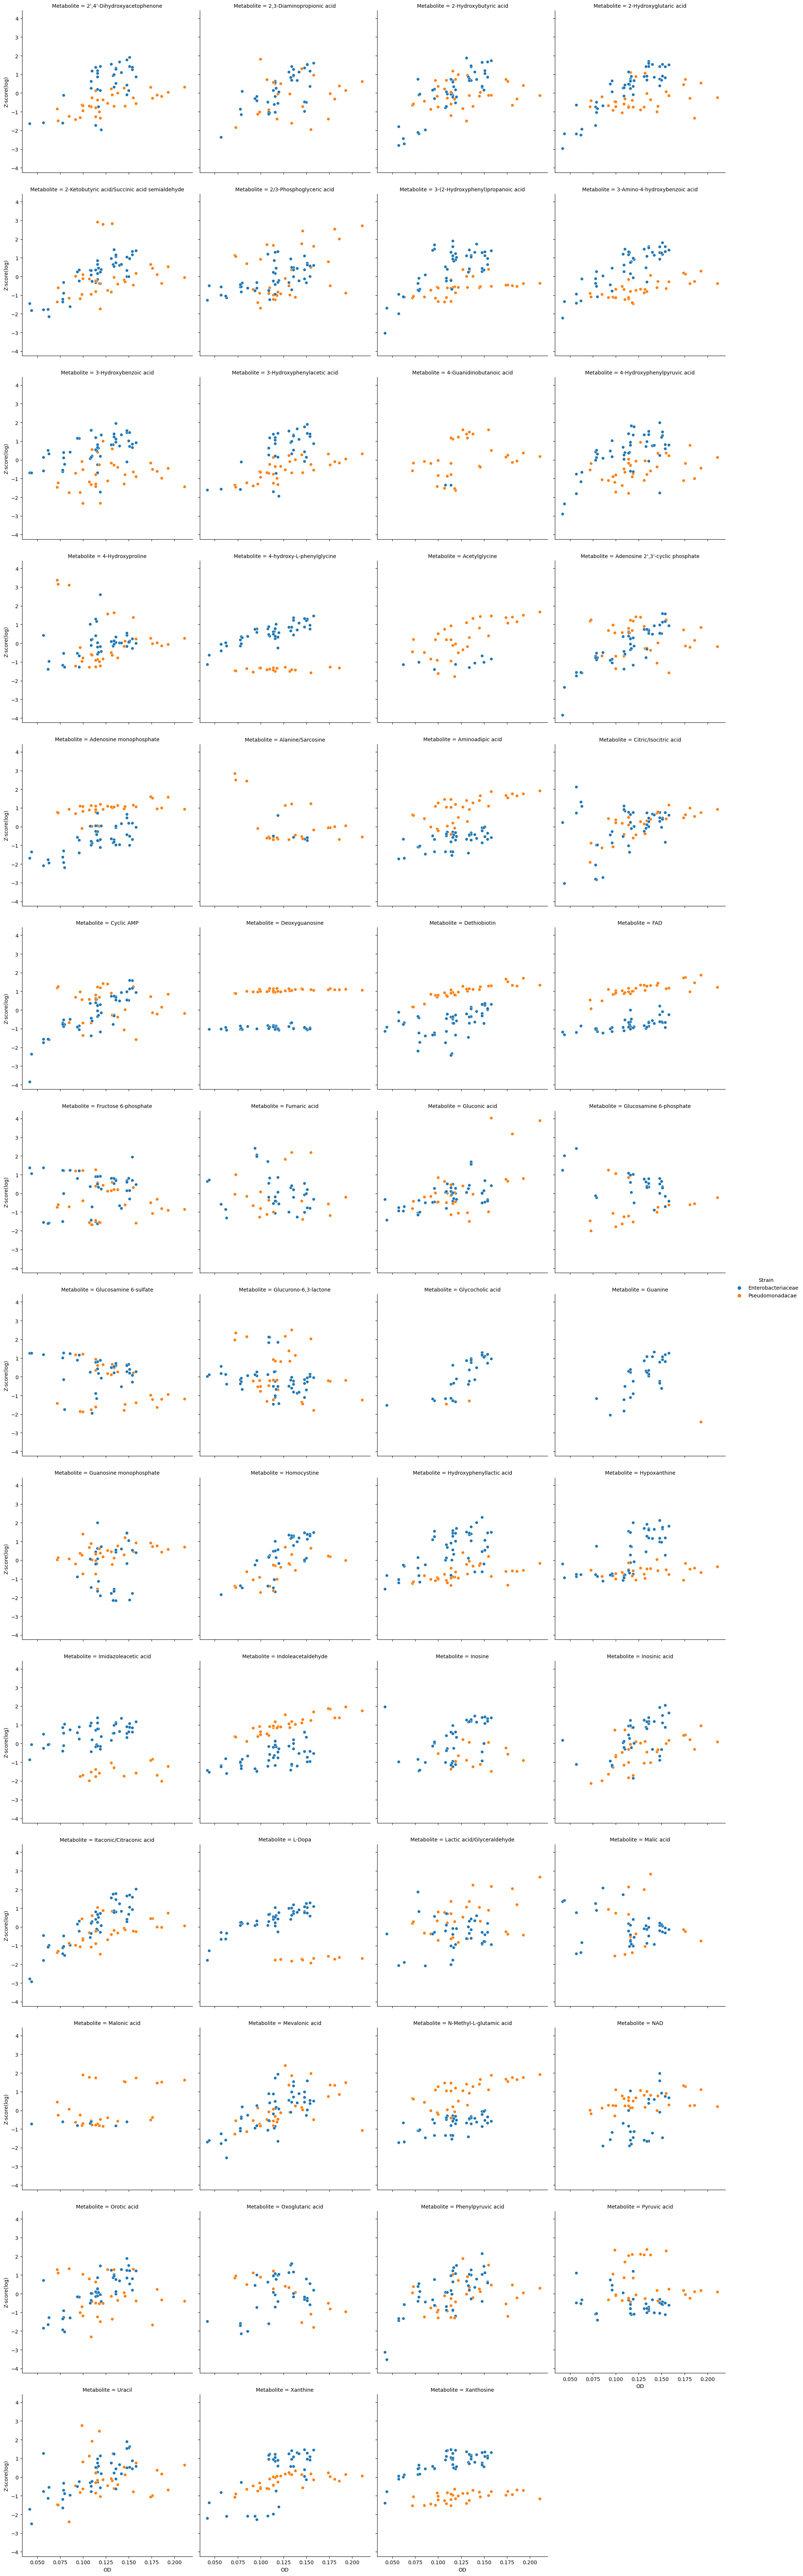

In [656]:
sns.relplot(data = dfu, x = 'OD', y = 'Z-score(log)', hue = 'Strain', col = 'Metabolite', col_wrap=4)
plt.show()

# Calculate metabolite values

In [657]:
fnmc = folder / 'ms_name_to_id_curated.csv'
dfmc = pd.read_csv(fnmc, index_col = 0)
translate_dict = dfmc[['Untargeted MS name', 'Metabolite ID']].set_index('Untargeted MS name').to_dict()['Metabolite ID']


In [658]:
translate_dict_r = {value:key for key, value in translate_dict.items()}

In [659]:
model_dict = {'Enterobacteriaceae': model_e,
              'Pseudomonadacae'   : model_p}

In [660]:
measured_mets = []
measured_metnames = []
for key, value in translate_dict.items():
    m_id = f'{value}_c'
    try:
        m = model_k.metabolites.get_by_id(m_id)
        m = model_p.metabolites.get_by_id(m_id)
    except KeyError:
        pass
    else:
        measured_mets.append(m_id)
        measured_metnames.append(key)
    

In [661]:
cs_to_exchange = {'D-Glucose': 'EX_glc__D_e',
                'D-Lactate': 'EX_lac__L_e',
                'Citrate': 'EX_cit_e',
                '2-Oxoglutarate': 'EX_akg_e',
                'Succinate': 'EX_succ_e',
                'Fumarate': 'EX_fum_e',
                'L-Malate': 'EX_mal__L_e',
                'L-Glutamine': 'EX_gln__L_e',
                'Acetate': 'EX_ac_e',
                'D-Galactose': 'EX_gal_e',
                'D-Ribose': 'EX_rib__D_e',
                'L-Arabinose': 'EX_arab__L_e',
                'Glycerol': 'EX_glyc_e',
                'D-Gluconate': 'EX_glcn_e',
                '2-Ketogluconate': 'EX_25dkglcn_e',
                'Pyruvate': 'EX_pyr_e'}

In [662]:
metabolite_value_dict = OrderedDict()
metabolite_value_list = []
for s in dfu.Strain.unique():
    strain_metabolite_value_dict = OrderedDict()
    model = model_dict[s]
    model.reactions.EX_glc__D_e.lower_bound = 0
    for cs, ex_id in cs_to_exchange.items():
        with model:
            try:
                r = model.reactions.get_by_id(ex_id)
            except KeyError:
                print(f'{ex_id} not in model')
                continue
            m_ex = r.metabolites.popitem()[0]
            try:
                nC = model_ez.metabolites.get_by_id(m_ex.id).elements['C']
            except KeyError:
                if len(m_ex.elements):
                    nC = m_ex.elements['C']
                else:
                    nC = 6
            lb = 30/nC
            # model.reactions.EX_pi_e.lower_bound = -1
            r.lower_bound = -lb
            solution = model.optimize()
            if solution.objective_value:
                # print(model.summary())

                # growth_dict[cs] = solution.objective_value
                strain_metabolite_value_dict[cs] = -solution.shadow_prices[measured_mets]
                for key, value in strain_metabolite_value_dict[cs].items():
                    m_name = translate_dict_r[key[:-2]]
                    metabolite_value_list.append([s, cs,m_name , value])
metabolite_value_dict[s] = strain_metabolite_value_dict

EX_25dkglcn_e not in model
EX_gal_e not in model
EX_arab__L_e not in model


In [663]:
met_value_df = pd.DataFrame(metabolite_value_list, columns = ['Strain', 'Carbon source', 'Metabolite', 'Metabolite value'])

In [664]:
met_value_df['log10(Metabolite value)'] = np.log10(met_value_df['Metabolite value'])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


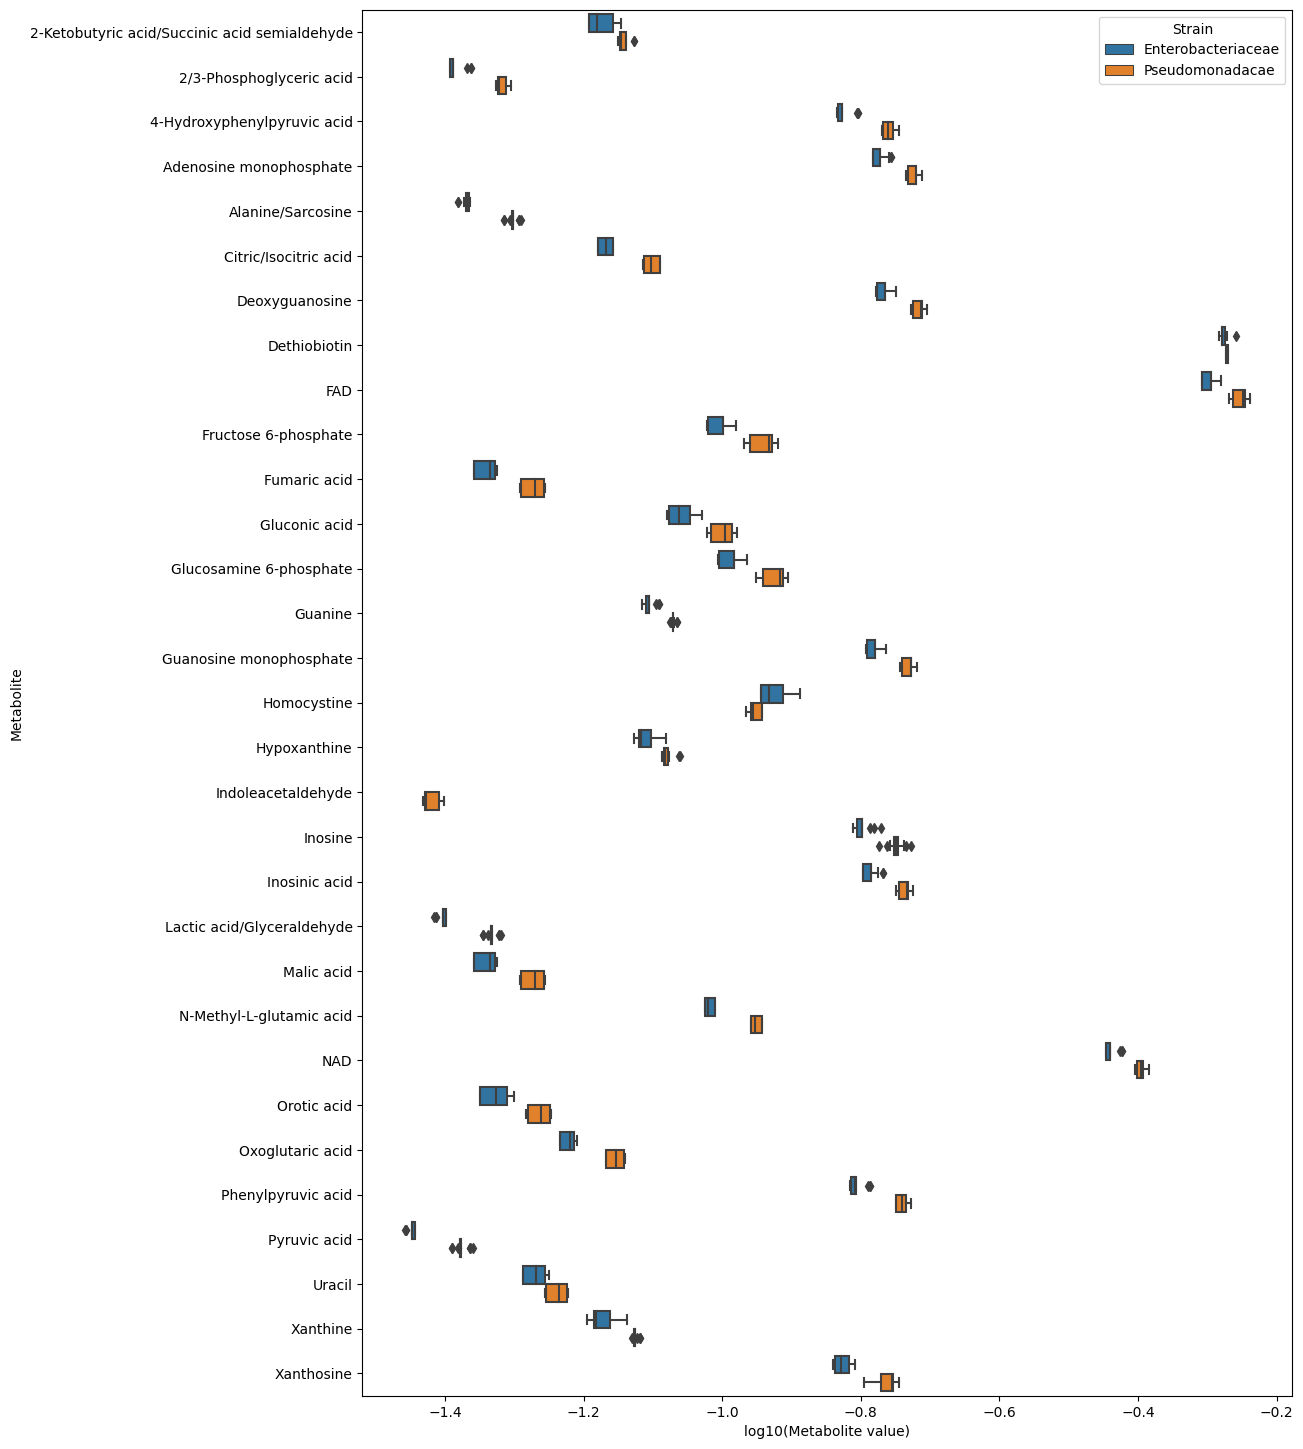

In [665]:
fig, ax = plt.subplots(1, figsize = (12,18))
sns.boxplot(data = met_value_df, x = 'log10(Metabolite value)', y = 'Metabolite',  hue = 'Strain')
plt.show()

In [666]:
met_value_df.groupby(['Strain', 'Metabolite']).std().reset_index().sort_values('log10(Metabolite value)')

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_3926/4166888742.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  met_value_df.groupby(['Strain', 'Metabolite']).std().reset_index().sort_values('log10(Metabolite value)')


,Strain,Metabolite,Metabolite value,log10(Metabolite value)
38,Pseudomonadacae,Dethiobiotin,0.001451,0.001178
44,Pseudomonadacae,Guanine,0.000521,0.002655
60,Pseudomonadacae,Xanthine,0.000557,0.003215
27,Enterobacteriaceae,Pyruvic acid,0.000425,0.005212
20,Enterobacteriaceae,Lactic acid/Glyceraldehyde,0.000498,0.005513
...,...,...,...,...
15,Enterobacteriaceae,Homocystine,0.004701,0.017006
43,Pseudomonadacae,Glucosamine 6-phosphate,0.004796,0.017701
40,Pseudomonadacae,Fructose 6-phosphate,0.004842,0.018575
24,Enterobacteriaceae,Orotic acid,0.002010,0.018622


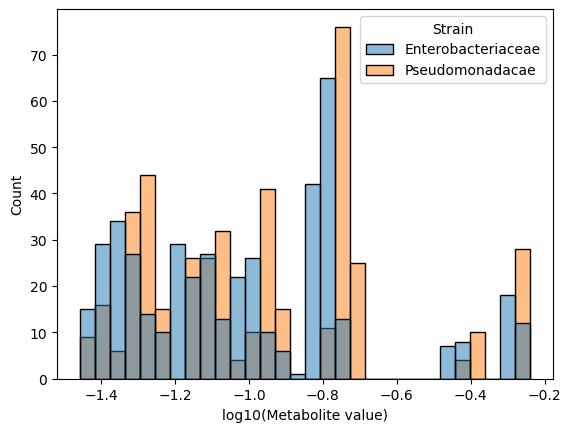

In [667]:
sns.histplot(data = met_value_df, x = 'log10(Metabolite value)', hue = 'Strain', bins=30)
plt.show()

## Normalize metabolite values

In [668]:
met_value_df.Metabolite.unique()

array(['2-Ketobutyric acid/Succinic acid semialdehyde',
       '2/3-Phosphoglyceric acid', '4-Hydroxyphenylpyruvic acid',
       'Adenosine monophosphate', 'Alanine/Sarcosine',
       'Citric/Isocitric acid', 'Deoxyguanosine', 'Dethiobiotin', 'FAD',
       'Fructose 6-phosphate', 'Fumaric acid', 'Gluconic acid',
       'Glucosamine 6-phosphate', 'Guanine', 'Guanosine monophosphate',
       'Homocystine', 'Hypoxanthine', 'Indoleacetaldehyde', 'Inosine',
       'Inosinic acid', 'Lactic acid/Glyceraldehyde', 'Malic acid',
       'N-Methyl-L-glutamic acid', 'NAD', 'Orotic acid',
       'Oxoglutaric acid', 'Phenylpyruvic acid', 'Pyruvic acid', 'Uracil',
       'Xanthine', 'Xanthosine'], dtype=object)

In [669]:
# met_value_df = met_value_df.loc[met_value_df.Metabolite != 'nad', :]
# met_value_df = met_value_df.loc[met_value_df.Metabolite != 'dtbt', :]
strains = dfu.Strain.unique()
met_value_df.replace([-np.inf, np.inf], np.nan, inplace=True)
s1 = strains[0]
s2 = strains[1]
sm1idx = met_value_df.Strain == s1
sm2idx = met_value_df.Strain == s2
# mean_key = 'Fumaric acid'#'acglu'
mean_idx = met_value_df.Metabolite == mean_key
# mean_mv_diff = met_value_df[sm1idx&mean_idx, 'log10(Metabolite value)'].mean() - met_value_df[sm2idx&mean_idx, 'log10(Metabolite value)'].mean()
met_value_df.loc[sm1idx, f'{mean_key}-log10(Metabolite value)'] = met_value_df.loc[sm1idx, 'log10(Metabolite value)'] - met_value_df.loc[sm1idx&mean_idx, 'log10(Metabolite value)'].median()
met_value_df.loc[sm2idx, f'{mean_key}-log10(Metabolite value)'] = met_value_df.loc[sm2idx, 'log10(Metabolite value)'] - met_value_df.loc[sm2idx&mean_idx, 'log10(Metabolite value)'].median()


for s in dfu.Strain.unique():
    sidx = met_value_df.Strain == s
    for key in ['Metabolite value', 'log10(Metabolite value)']:
        zkey = f'Z-{key}'
        met_value_df.loc[sidx, key].replace([-np.inf, np.inf], np.nan, inplace = True)
        met_value_df.loc[sidx, zkey] = (met_value_df.loc[sidx, key] - met_value_df.loc[sidx, key].mean()) / met_value_df.loc[sidx, key].std()


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


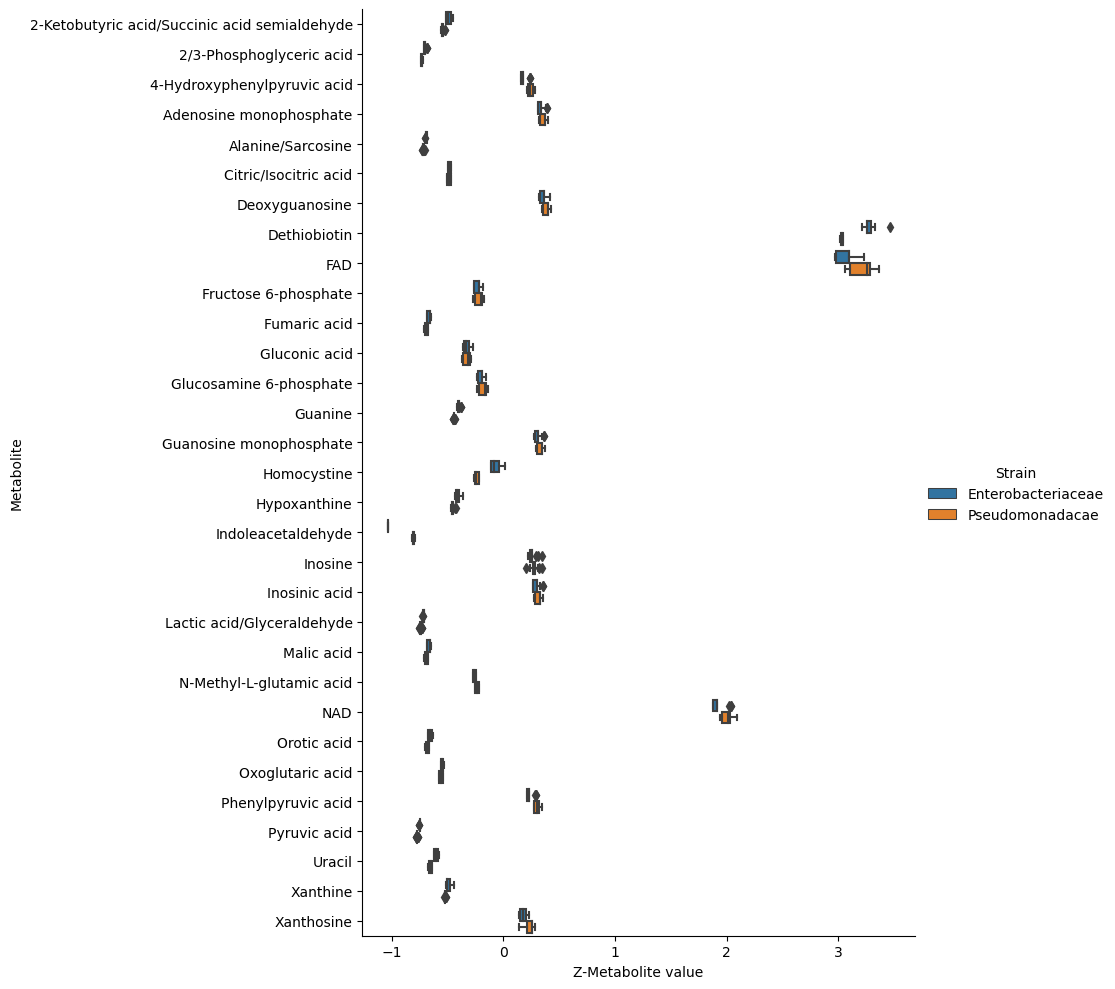

In [670]:
sns.catplot(data = met_value_df, x = 'Z-Metabolite value', y = 'Metabolite', hue = 'Strain', height = 10, kind = 'box')
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


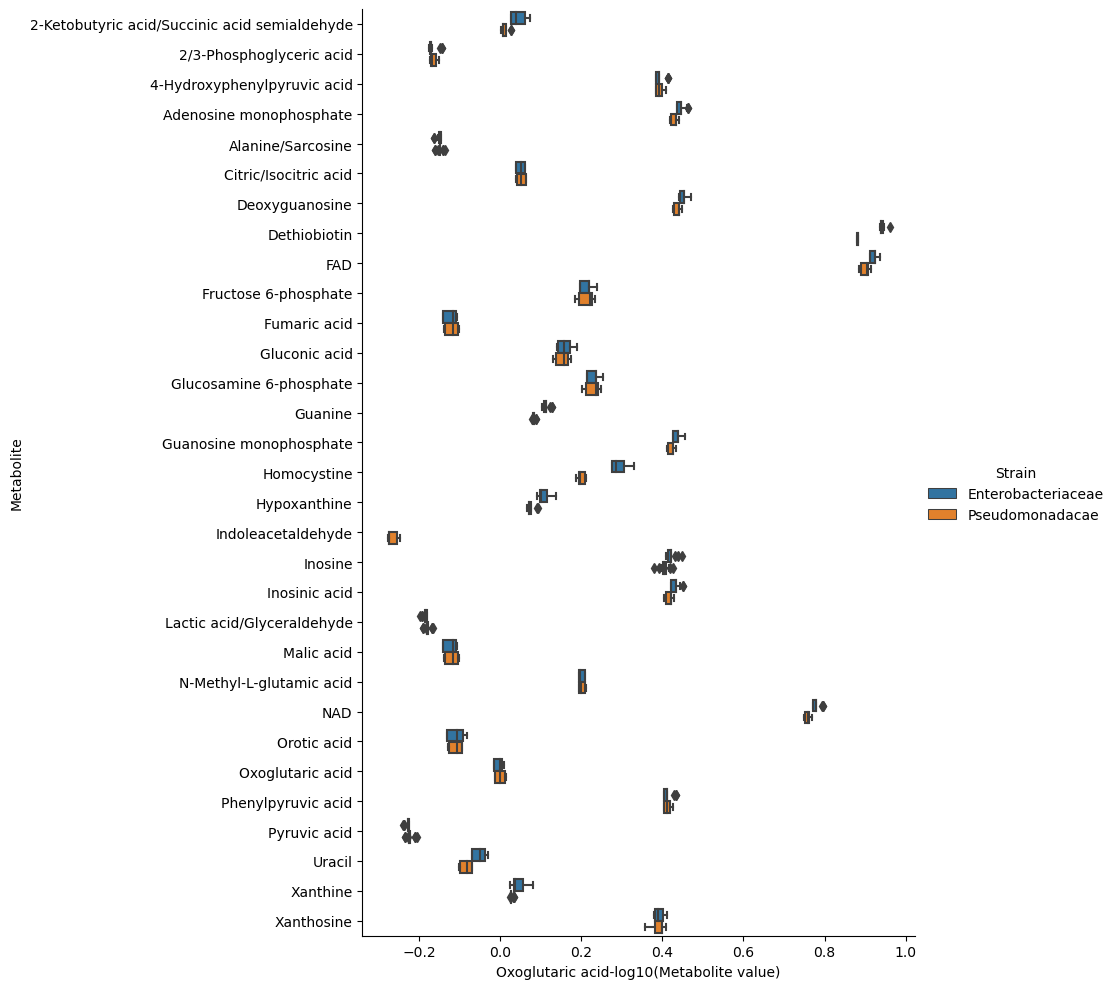

In [671]:
sns.catplot(data = met_value_df, x = f'{mean_key}-log10(Metabolite value)', y = 'Metabolite', hue = 'Strain', height = 10, kind = 'box')
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


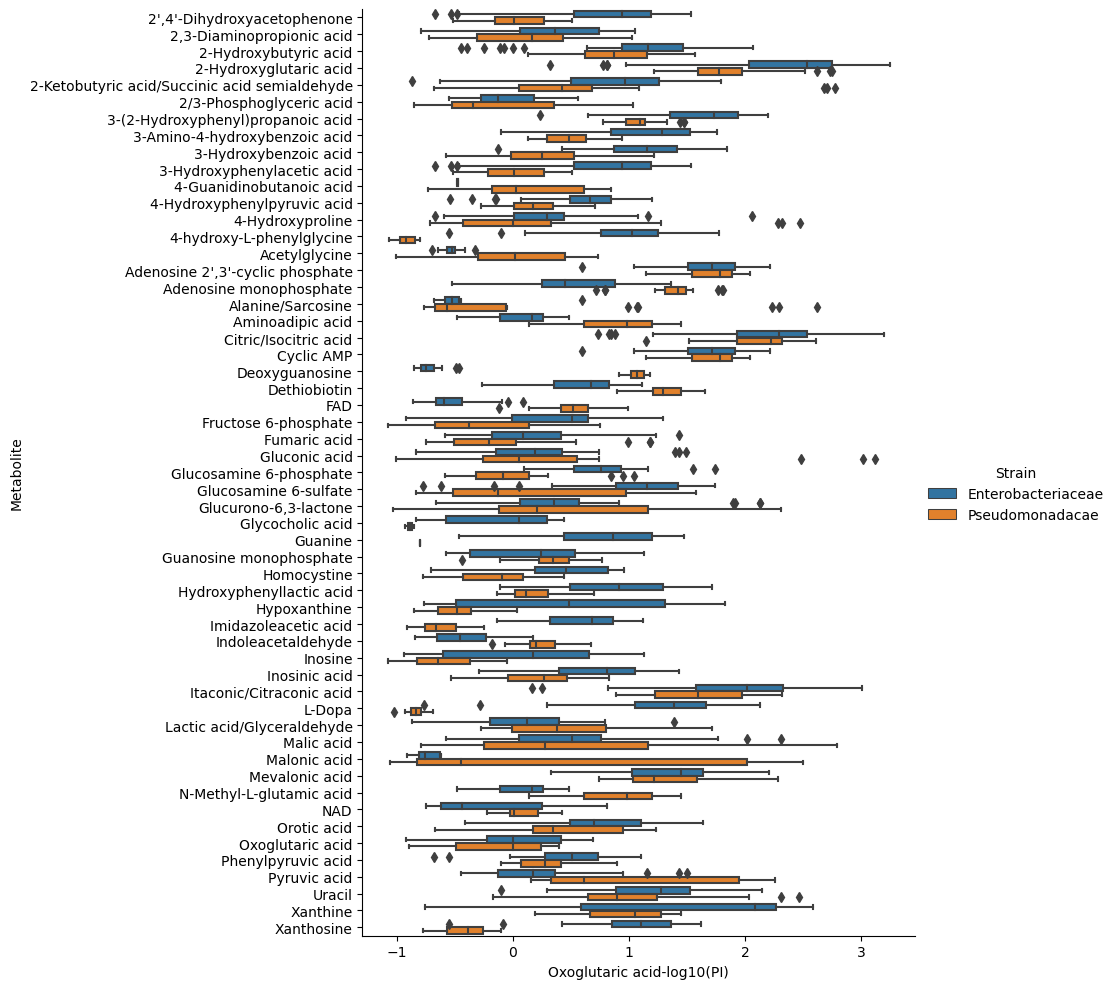

In [672]:
x = f'{mean_key}-log10(PI)'
y = 'Metabolite'
sns.catplot(data = dfu, x = x, y = y, hue = 'Strain', kind = 'box', height=10, aspect=1)#, order = order)
plt.show()

In [673]:
# key = f'{mean_key}-log10(PI)'
# sidx = dfu.Species == s1
# for m in measured_metnames:
#     midx = dfu.Metabolite == m
#     x = dfu.loc[idx
    

In [674]:
met_value_df

,Strain,Carbon source,Metabolite,Metabolite value,log10(Metabolite value),Oxoglutaric acid-log10(Metabolite value),Z-Metabolite value,Z-log10(Metabolite value)
0,Enterobacteriaceae,D-Glucose,2-Ketobutyric acid/Succinic acid semialdehyde,0.069591,-1.157447,0.061396,-0.471420,-0.481749
1,Enterobacteriaceae,D-Glucose,2/3-Phosphoglyceric acid,0.040438,-1.393210,-0.174367,-0.708991,-1.238788
2,Enterobacteriaceae,D-Glucose,4-Hydroxyphenylpyruvic acid,0.146705,-0.833554,0.385289,0.156993,0.558276
3,Enterobacteriaceae,D-Glucose,Adenosine monophosphate,0.165044,-0.782401,0.436441,0.306433,0.722527
4,Enterobacteriaceae,D-Glucose,Alanine/Sarcosine,0.043259,-1.363921,-0.145078,-0.686000,-1.144740
...,...,...,...,...,...,...,...,...
894,Pseudomonadacae,Pyruvate,Phenylpyruvic acid,0.187444,-0.727127,0.426460,0.346049,0.784582
895,Pseudomonadacae,Pyruvate,Pyruvic acid,0.040797,-1.389375,-0.235787,-0.786273,-1.352813
896,Pseudomonadacae,Pyruvate,Uracil,0.058439,-1.233300,-0.079713,-0.650054,-0.849086
897,Pseudomonadacae,Pyruvate,Xanthine,0.076080,-1.118727,0.034860,-0.513835,-0.479302


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


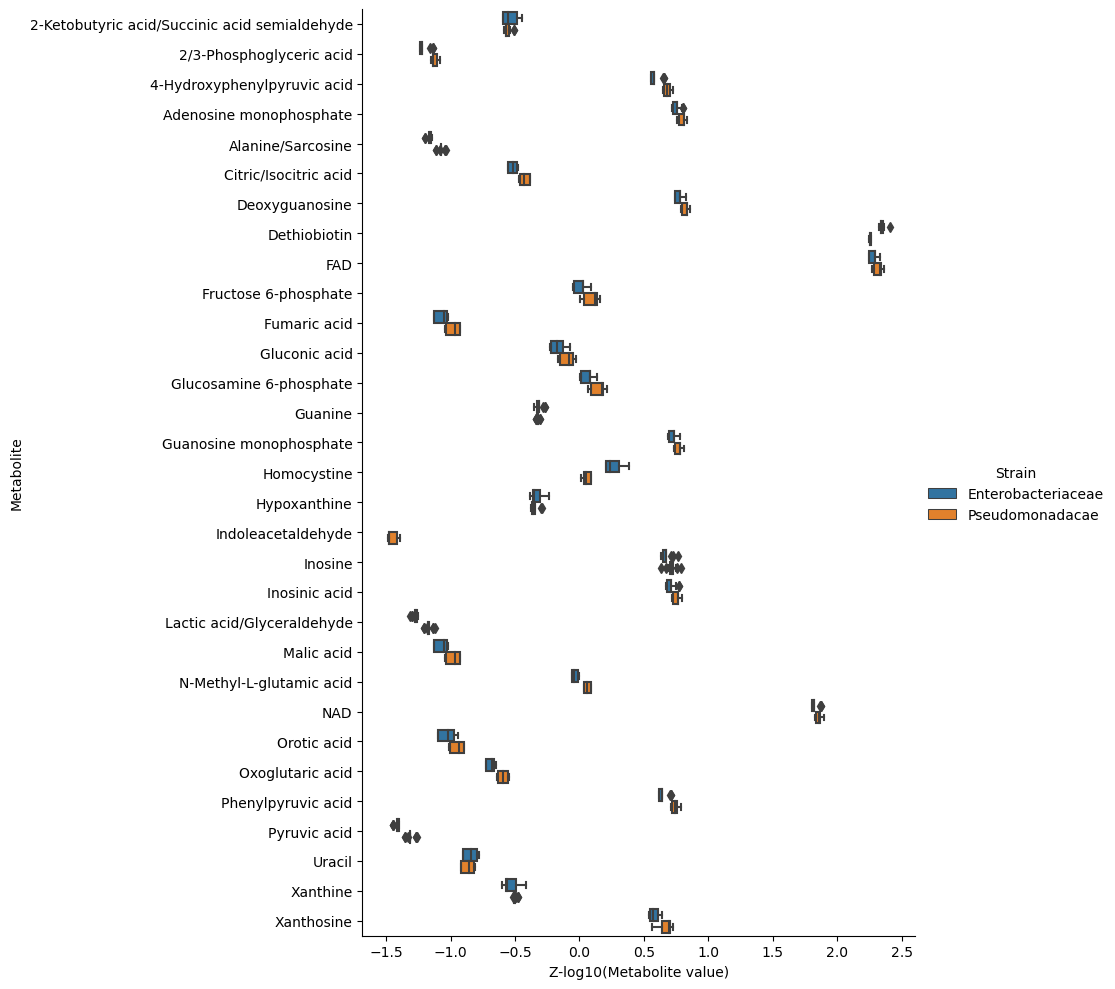

In [675]:
sns.catplot(data = met_value_df, x = 'Z-log10(Metabolite value)', y = 'Metabolite', hue = 'Strain', height = 10, kind = 'box')
plt.show()

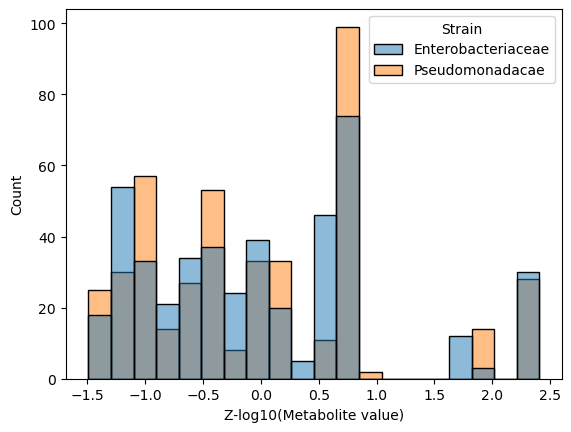

In [676]:
sns.histplot(data = met_value_df, x = 'Z-log10(Metabolite value)', hue = 'Strain', bins = 20)
plt.show()

In [677]:
strains = dfu.Strain.unique()
# key1 = 'Z-log10(Metabolite value)'
key1 = f'{mean_key}-log10(Metabolite value)'
key2 = f'{mean_key}-log10(PI)'
data = []

s1 = strains[0]
s2 = strains[1]

sm1idx = met_value_df.Strain == s1
sm2idx = met_value_df.Strain == s2
    
s1idx = dfu.Strain == s1
s2idx = dfu.Strain == s2

for s in strains:
    smidx = met_value_df.Strain == s
    sidx = dfu.Strain == s
    for m in measured_metnames:
        midx = met_value_df.Metabolite == m
        carbon_sources = met_value_df.loc[midx&smidx, 'Carbon source'].unique()
        for cs in carbon_sources:
            cs_idx = met_value_df['Carbon source'] == cs
            mval = met_value_df.loc[smidx&midx&cs_idx,key1].median()# - met_value_df.loc[sm2idx&midx&cs_idx,key1].mean()


            mcidx = dfu.Metabolite == m
            scidx = dfu.Carbon_Source == cs
            type_ = cs_to_type_map[cs]
            conc = dfu.loc[sidx&mcidx&scidx,key2].median() 
            data.append([s, m, cs, type_, mval, conc])

In [678]:
df = pd.DataFrame(data, columns=['Strain', 'Metabolite', 'Carbon source', 'Sugar/Acid', 'Metabolite value', 'Concentration'])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


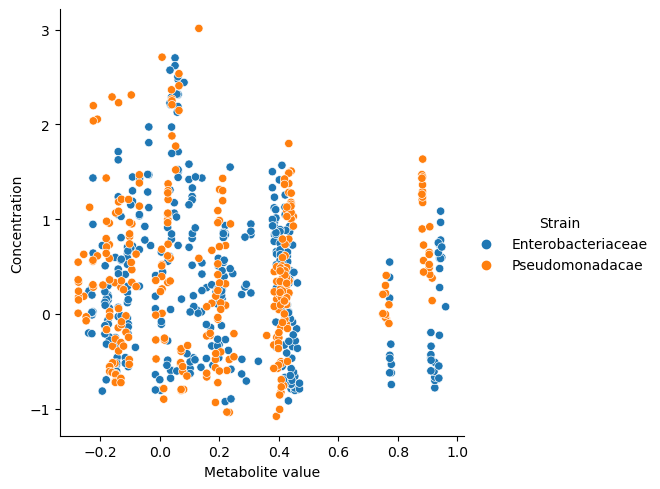

In [679]:
sns.relplot(data = df, x = 'Metabolite value', y = 'Concentration', hue = 'Strain')
plt.show()

In [680]:
dfu.head()

,SID,Metabolite,Peak_Intensity,Strain,SangerID,Carbon_Source,Well,Plate,OD,Replicate,Type,Z-score,Z-score(log),log10(PI),Fumaric acid-log10(PI),Gluconic acid-log10(PI),Oxoglutaric acid-log10(PI)
0,C1_E1,"2',4'-Dihydroxyacetophenone",21466.33,Enterobacteriaceae,360,D-Glucose,B1,1,0.151,1,S,4.019165,1.904485,4.331758,1.449421,1.340678,1.532645
1,C1_E1,"2,3-Diaminopropionic acid",6622.67,Enterobacteriaceae,360,D-Glucose,B1,1,0.151,1,S,2.565562,1.545756,3.821033,0.938696,0.829953,1.021920
2,C1_E1,2-Hydroxybutyric acid,31576.00,Enterobacteriaceae,360,D-Glucose,B1,1,0.151,1,S,1.294324,1.193485,4.499357,1.617020,1.508277,1.700244
3,C1_E1,2-Hydroxyglutaric acid,880990.69,Enterobacteriaceae,360,D-Glucose,B1,1,0.151,1,S,2.569016,1.532504,5.944971,3.062635,2.953892,3.145858
4,C1_E1,2-Ketobutyric acid/Succinic acid semialdehyde,16728.67,Enterobacteriaceae,360,D-Glucose,B1,1,0.151,1,S,-0.066832,0.932650,4.223461,1.341125,1.232382,1.424348


In [690]:
strains = dfu.Strain.unique()
# key1 = 'log10(Metabolite value)'
key1 = f'{mean_key}-log10(Metabolite value)'
key2 = f'{mean_key}-log10(PI)'
# key2 = 'Z-score(log)'
data = []

s1 = strains[0]
s2 = strains[1]

sm1idx = met_value_df.Strain == s1
sm2idx = met_value_df.Strain == s2
    
s1idx = dfu.Strain == s1
s2idx = dfu.Strain == s2

    
for m in measured_metnames:
    midx = met_value_df.Metabolite == m
    carbon_sources_s1 = met_value_df.loc[midx&sm1idx, 'Carbon source'].unique()
    carbon_sources_s2 = met_value_df.loc[midx&sm2idx, 'Carbon source'].unique()
    carbon_sources = [x for x in carbon_sources_s1 if x in carbon_sources_s2]
    for cs in carbon_sources:
        cs_idx = met_value_df['Carbon source'] == cs
        mv_diff = met_value_df.loc[sm1idx&midx&cs_idx,key1].mean() - met_value_df.loc[sm2idx&midx&cs_idx,key1].mean()
    
        
        mcidx = dfu.Metabolite == m
        scidx = dfu.Carbon_Source == cs
        type_ = cs_to_type_map[cs]
        conc_diff = dfu.loc[s1idx&mcidx&scidx,key2].mean() - dfu.loc[s2idx&mcidx&scidx,key2].mean()
        data.append([m, cs, type_, mv_diff, conc_diff])

In [691]:
dd_diff = pd.DataFrame(data, columns = ['Metabolite', 'Carbon source', 'Sugar/Acid', 'Metabolite value diff', 'Concentration diff'])

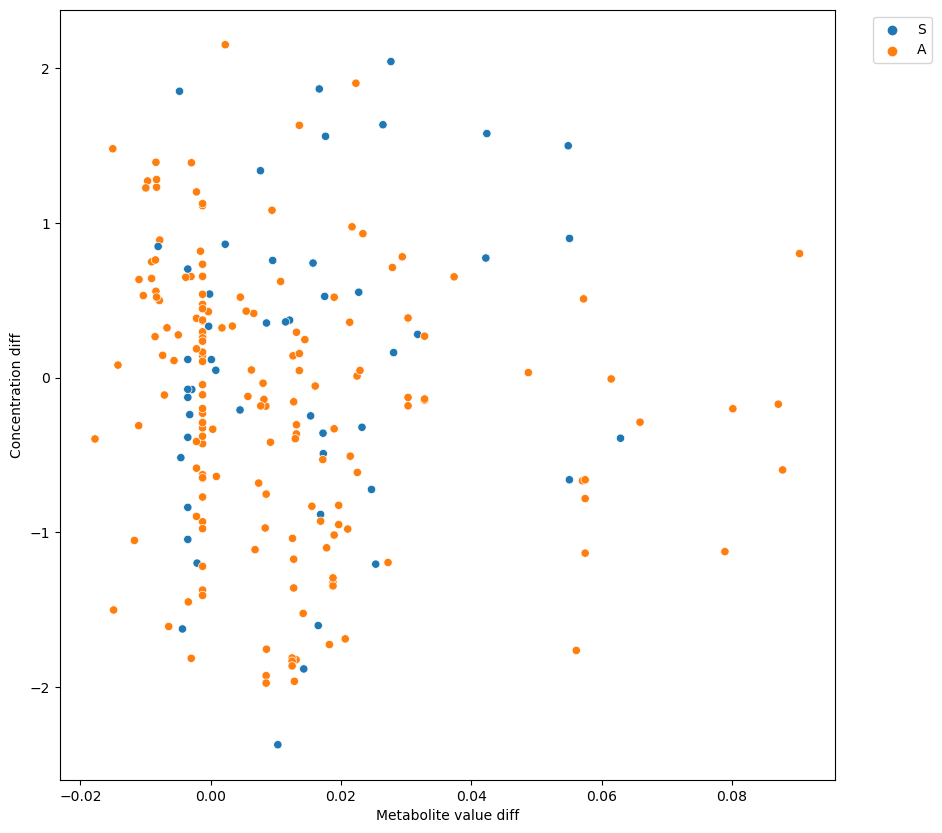

In [692]:
fig, ax = plt.subplots(1, figsize = (10,10))
sns.scatterplot(data=dd_diff, x = 'Metabolite value diff', y = 'Concentration diff', ax = ax, hue = 'Sugar/Acid')
# plt.xlim(-0.05, 0.05)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [694]:
dd_diff['Metabolite value diff'].mean()

0.013067033122977731

In [693]:
x_arr = []
y_arr = []
for x, y in zip(dd_diff['Metabolite value diff'], dd_diff['Concentration diff']):
    if np.isfinite(x) and np.isfinite(y):
        x_arr.append(x)
        y_arr.append(y)
print(st.spearmanr(x_arr, y_arr))
print(st.pearsonr(x_arr, y_arr))

SignificanceResult(statistic=-0.15859111288278557, pvalue=0.01941254485114341)
PearsonRResult(statistic=-0.08424208769658958, pvalue=0.21646068511240515)


## Look at statistical differences

In [695]:
strains = dfu.Strain.unique()
key1 = 'Z-log10(Metabolite value)'
# key1 = 'Z-log10(Metabolite value)'
# key1 = f'{mean_key}-log10(Metabolite value)'
# key2 = f'{mean_key}-log10(PI)'
key2 = 'Z-score(log)'
data = []

s1 = strains[0]
s2 = strains[1]

sm1idx = met_value_df.Strain == s1
sm2idx = met_value_df.Strain == s2
    
s1idx = dfu.Strain == s1
s2idx = dfu.Strain == s2
pval_lim = 0.01
cpval_lim = 0.01
    
for m in measured_metnames:
    midx = met_value_df.Metabolite == m
    mval1 = met_value_df.loc[sm1idx&midx,key1]-dd_diff['Metabolite value diff'].mean()
    mval2 = met_value_df.loc[sm2idx&midx,key1]
    x1_arr = []
    x2_arr = []
    for x1, x2 in zip(mval1.values, mval2.values):
        if np.isfinite(x1) and np.isfinite(x2):
            x1_arr.append(x1)
            x2_arr.append(x2)

    mtscore = st.ttest_ind(x1_arr, x2_arr, equal_var=False)
    mdiff = np.mean(x1_arr)-np.mean(x2_arr)
    if mtscore.pvalue < pval_lim:
        mq = np.sign(mdiff)
    else:
        mq = 0
    
    
    
    mcidx = dfu.Metabolite == m
    cval1 = dfu.loc[s1idx&mcidx,key2]
    cval2 = dfu.loc[s2idx&mcidx,key2]

    c1_arr = []
    c2_arr = []
    for c1, c2 in zip(cval1.values, cval2.values):
        if np.isfinite(c1) and np.isfinite(c2):
            c1_arr.append(c1)
            c2_arr.append(c2)

    ctscore = st.ttest_ind(c1_arr, c2_arr, equal_var=False)
    cdiff = np.mean(c1_arr)-np.mean(c2_arr)
    if ctscore.pvalue < cpval_lim:
        cq = np.sign(cdiff)
    else:
        cq = 0
    
    
    
    data.append([m, mdiff, mtscore.pvalue, mq, cdiff, ctscore.pvalue, cq])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [696]:
ttest_df = pd.DataFrame(data, columns = ['Metabolite', 'Met diff', 'Met p-value', 'Met Q', 'C diff', 'C p-value', 'C Q'])

In [697]:
ttest_df['Correct'] = ttest_df['Met Q'] == ttest_df['C Q']

In [698]:
mean_key

'Oxoglutaric acid'

In [699]:
# ttest_df['C diff'] = ttest_df['C diff'] - ttest_df['C diff'].median()
# ttest_df['Met diff'] = ttest_df['Met diff'] - ttest_df['Met diff'].median()

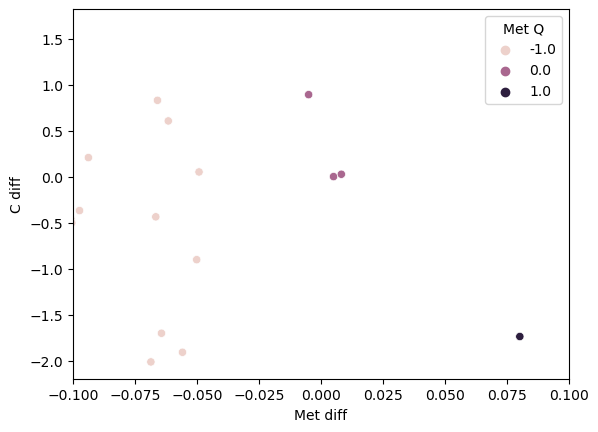

In [700]:
sns.scatterplot(data = ttest_df, x = 'Met diff', y = 'C diff', hue = 'Met Q')
plt.xlim([-0.1, 0.1])
plt.show()

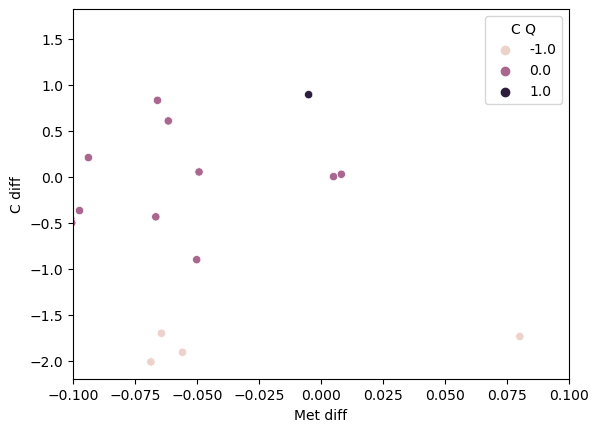

In [701]:
sns.scatterplot(data = ttest_df, x = 'Met diff', y = 'C diff', hue = 'C Q')
plt.xlim([-0.1, 0.1])
plt.show()

In [702]:
print(np.sum(ttest_df['Met Q'] == ttest_df['C Q']), len(ttest_df))

9 31


In [305]:
from sklearn.metrics import confusion_matrix

In [307]:
cm = confusion_matrix(ttest_df['C Q'], ttest_df['Met Q'])

In [345]:
ttest_df['C Q'].value_counts()

 0.0    18
-1.0    11
 1.0     2
Name: C Q, dtype: int64

In [703]:
N = len(ttest_df['C Q'])
# rv = sp.stats.multivariate_hypergeom(ttest_df['C Q'].value_counts().values, n = N)
ns = 1000
output = np.random.choice([0, -1, 1], size = [ns, N])# p = [18/31, 11/31, 2/31]
truth = ttest_df['C Q'].values

In [704]:
correct = np.zeros(ns)
for i in range(ns):
    correct[i] = np.sum(output[i]==truth)
print((correct>16).sum()/ns)

0.011


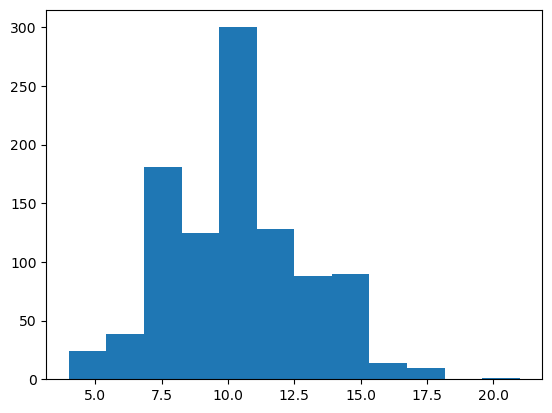

In [708]:
plt.hist(correct, bins = 12)
plt.show()

In [88]:
translate_dict

{"2',4'-Dihydroxyacetophenone": nan,
 '2,3-Diaminopropionic acid': '23dappa',
 '2-Hydroxybutyric acid': '2hb',
 '2-Hydroxyglutaric acid': 'S2hglut',
 '2-Ketobutyric acid/Succinic acid semialdehyde': '2obut',
 '2/3-Phosphoglyceric acid': '3pg',
 '3-(2-Hydroxyphenyl)propanoic acid': 'dhpppn',
 '3-Amino-4-hydroxybenzoic acid': nan,
 '3-Hydroxybenzoic acid': '3hbz',
 '3-Hydroxyphenylacetic acid': '3hoxpac',
 '4-Guanidinobutanoic acid': '4gudbutn',
 '4-Hydroxyphenylpyruvic acid': '34hpp',
 '4-Hydroxyproline': '4hpro_LT',
 '4-hydroxy-L-phenylglycine': nan,
 'Acetylglycine': 'acgly',
 "Adenosine 2',3'-cyclic phosphate": nan,
 'Adenosine monophosphate': 'amp',
 'Alanine/Sarcosine': 'ala__L',
 'Aminoadipic acid': 'L2aadp',
 'Citric/Isocitric acid': 'cit',
 'Cyclic AMP': '23camp',
 'Deoxyguanosine': 'dgsn',
 'Dethiobiotin': 'dtbt',
 'FAD': 'fad',
 'Fructose 6-phosphate': 'f6p',
 'Fumaric acid': 'fum',
 'Gluconic acid': 'glcn',
 'Glucosamine 6-phosphate': 'gam6p',
 'Glucosamine 6-sulfate': nan,
 